In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import train_test_split
from pysindy import SINDy
from sklearn.preprocessing import StandardScaler
from pysindy.optimizers import STLSQ
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix 

In [5]:
df = pd.read_csv("processed_well_data.csv")

In [6]:
print(df.isnull().sum())

Well no                    0
Dia                        0
Dev(deg)                   0
LiquidFlowrate             0
Gasflowrate                0
Area (m2)                  0
z                          0
GasDens                    0
Condesnate Presence        0
Water presence             0
LiquidDens                 0
GasVis                     0
LiqVis                     0
g (m/s2)                   0
Test Vg                    0
P/T                        0
Test status                0
Vsg                        0
Vsl                        0
Rel                        0
Reg                        0
film thickness             0
d(0,90)                    0
d(15,90)                   0
d(30,90)                   0
d(45,90)                   0
d(60,90)                   0
d(90,90)                   0
d(120,90)                  0
d(150,90)                  0
d(180,90)                  0
d(210,90)                  0
d(270,90)                  0
d(360,90)                  0
friction_facto

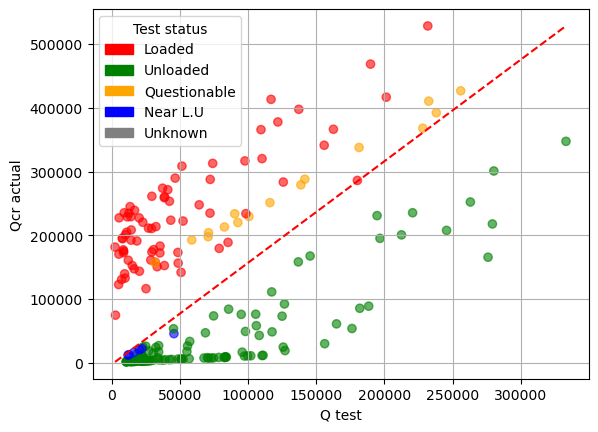

In [7]:
color_map = {
    "Loaded": "red",
    "Unloaded": "green",
    "Questionable": "orange",
    "Near L.U": "blue"
}

colors = df['Test status'].map(color_map).fillna("gray")

plt.scatter(df["Gasflowrate"], df["Qcr"], c=colors, alpha=0.6, label="gplearn Predictions")
plt.plot([min(df["Gasflowrate"]), max(df["Gasflowrate"])], [min(df["Qcr"]), max(df["Qcr"])], '--r', label='Perfect Fit (y=x)')
plt.xlabel("Q test")
plt.ylabel("Qcr actual")
plt.grid(True)


legend_patches = [mpatches.Patch(color=color, label=status) for status, color in color_map.items()]
legend_patches.append(mpatches.Patch(color="gray", label="Unknown"))
plt.legend(handles=legend_patches, title='Test status')

plt.show()



# Data preparation 

In [8]:
# Split features
X = df[['Dia', 'Dev(deg)','Area (m2)', 'z','GasDens','LiquidDens', 'P/T','friction_factor', 'critical_film_thickness']]
y = df['Qcr']
gsflow = df['Gasflowrate']  # This is your additional target for classification metrics

# Perform the train-test split, making sure to split all targets simultaneously
X_train, X_test, y_train, y_test, gsflow_train, gsflow_test = train_test_split(
    X, y, gsflow, test_size=0.2, random_state=42
)

# Scale your features and continuous target (Qcr)
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
X_scaled = scaler_X.transform(X)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))


# t_train is just an index array for plotting
t_train = np.arange(len(y_train_scaled))

#convert to a numpy array 
gsflow_test = np.array(gsflow_test)
y_test = np.array(y_test)

# SINDy Model without Regularization

In [10]:
sindy_model = SINDy()
sindy_model.fit(X_train_scaled, t=t_train, x_dot =y_train_scaled)

y_pred_sindy_scaled = sindy_model.predict(X_test_scaled)
y_pred_sindy = scaler_y.inverse_transform(y_pred_sindy_scaled)

mse_sindy = mean_squared_error(y_test, y_pred_sindy)
r2_sindy = r2_score(y_test, y_pred_sindy)

print("SINDy Equation:")
sindy_model.print()
print(f"SINDy MSE: {mse_sindy:.4f}, R2: {r2_sindy:.4f}\n")

"""
Compute classification score 

    Qcr > Qtest --> loaded 
    Qcr < Qtest --> unloaded 
    Qcr ~ Qtest --> near-loaded
"""
intv = 6000
loading_test = [
    1 if y_pred_sindy[i] > gsflow_test[i] + intv 
    else (-1 if y_pred_sindy[i] < gsflow_test[i] - intv 
          else 0) 
    for i in range(len(y_pred_sindy))
]

loading_actual = [
    1 if y_test[i] > gsflow_test[i] + intv 
    else (-1 if y_test[i] < gsflow_test[i] - intv 
          else 0) 
    for i in range(len(y_test))
]
print(loading_test)
print(loading_actual)
acc = accuracy_score(loading_actual, loading_test)
print(f"Accuracy of classifier: {acc * 100}%")

SINDy Equation:
(x0)' = -1.696 x0 + 5.202 x3 + 10.864 x4 + 0.367 x5 + 1.306 x6 + -2.626 x7 + 2.662 x8 + -1.335 x0^2 + -1.743 x0 x1 + 0.054 x0 x2 + 0.293 x0 x3 + -1.594 x0 x5 + -1.446 x0 x6 + -6.174 x0 x7 + 0.975 x0 x8 + 0.685 x1^2 + 1.183 x1 x2 + -5.368 x1 x3 + 2.523 x1 x4 + 1.398 x1 x5 + -0.894 x1 x7 + 1.775 x2^2 + 6.908 x2 x4 + 2.459 x2 x6 + 5.330 x2 x7 + -1.330 x2 x8 + -0.228 x3 x4 + 0.449 x3 x5 + 0.690 x3 x6 + 0.872 x3 x7 + -1.027 x3 x8 + 1.202 x4 x5 + -3.072 x4 x6 + 13.711 x4 x7 + -3.294 x4 x8 + 0.963 x5^2 + -0.333 x5 x6 + -2.535 x5 x7 + 0.929 x5 x8 + 0.738 x6 x7 + 0.433 x7^2 + -0.759 x7 x8 + 0.193 x8^2
SINDy MSE: 11743611217.7763, R2: 0.2965

[1, -1, -1, 1, 0, 1, 1, -1, -1, 1, -1, 1, -1, 1, -1, 1, 1, 1, -1, 1, -1, -1, 1, 1, 0, 1, 1, -1, 1, 1, 1, 0, -1, 1, -1, 1, -1, -1, 1, -1, -1, 1]
[1, 1, -1, 1, -1, -1, -1, -1, 1, 1, -1, 1, 1, -1, -1, 1, 1, -1, -1, -1, -1, -1, 1, -1, -1, 1, 1, 1, -1, 1, 1, -1, -1, 1, 1, 1, -1, -1, 1, 0, -1, 0]
Accuracy of classifier: 59.523809523809526%


# SINDy Model Hyperparmaeter optimization

In [24]:
import numpy as np
from sklearn.model_selection import KFold
from pysindy import SINDy, STLSQ
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

def calculate_accuracy(y_true, y_pred, gsflow, interval):
    loading_pred = np.where(y_pred > gsflow + interval, 1, 
                          np.where(y_pred < gsflow - interval, -1, 0))
    loading_actual = np.where(y_true > gsflow + interval, 1, 
                            np.where(y_true < gsflow - interval, -1, 0))
    return accuracy_score(loading_actual, loading_pred)

def evaluate_sindy(params, X, y, gsflow, cv_splits=5):
    alpha, threshold, interval = params
    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=42)
    acc_scores = []
    
    for train_idx, val_idx in kf.split(X):  # Using validation split from training data
        X_train_cv, X_val_cv = X[train_idx], X[val_idx]
        y_train_cv, y_val_cv = y[train_idx], y[val_idx]
        gsflow_val_cv = gsflow[val_idx]
        
        scaler_X = StandardScaler()
        X_train_cv_scaled = scaler_X.fit_transform(X_train_cv)
        X_val_cv_scaled = scaler_X.transform(X_val_cv)
        
        scaler_y = StandardScaler()
        y_train_cv_scaled = scaler_y.fit_transform(y_train_cv.reshape(-1, 1))
        
        optimizer = STLSQ(
            alpha=alpha,
            threshold=threshold,
            max_iter=10000,
            normalize_columns=True
        )
        
        model = SINDy(optimizer=optimizer)
        model.fit(X_train_cv_scaled, t=np.arange(len(y_train_cv_scaled)), 
                 x_dot=y_train_cv_scaled)
        
        y_pred_scaled = model.predict(X_val_cv_scaled)
        y_pred = scaler_y.inverse_transform(y_pred_scaled).flatten()
        
        acc = calculate_accuracy(y_val_cv, y_pred, gsflow_val_cv, interval)
        acc_scores.append(acc)
    
    return np.mean(acc_scores)

def optimize_sindy_hyperparameters(X_train, y_train, gsflow_train, param_grid):
    best_score = -1
    best_params = None
    
    X_train = np.array(X_train)
    y_train = np.array(y_train).flatten()
    gsflow_train = np.array(gsflow_train)
    
    print("Starting hyperparameter optimization...")
    for alpha in param_grid['alpha']:
        for threshold in param_grid['threshold']:
            for interval in param_grid['interval']:
                score = evaluate_sindy((alpha, threshold, interval), 
                                     X_train, y_train, gsflow_train)
                
                if score > best_score:
                    best_score = score
                    best_params = {'alpha': alpha, 'threshold': threshold, 'interval': interval}
    
    return best_params, best_score

# Parameter grid (adjust ranges based on your domain knowledge)
param_grid = {
    'alpha': np.logspace(-4, 0, 10),      # Reduced number for faster testing
    'threshold': np.logspace(-4, 0, 10),  # Reduced number for faster testing
    'interval': np.linspace(0, 10, 10)  # Example values
}

# Run optimization using ONLY training data
best_params, best_score = optimize_sindy_hyperparameters(
    X_train_scaled, y_train, gsflow_train, param_grid
)

print("\nBest parameters found:")
print(best_params)
print(f"Best CV accuracy: {best_score*100:.2f}%")

# Train final model on FULL training set with best params
final_optimizer = STLSQ(
    alpha=best_params['alpha'],
    threshold=best_params['threshold'],
    max_iter=10000,
    normalize_columns=True
)

final_model = SINDy(optimizer=final_optimizer)
final_model.fit(X_train_scaled, t=t_train, x_dot=y_train_scaled)

# Evaluate on trainin set
y_pred_train_scaled = final_model.predict(X_train_scaled)
y_pred_train = scaler_y.inverse_transform(y_pred_train_scaled).flatten()

# Evaluate on TEST set (previously unseen data)
y_pred_test_scaled = final_model.predict(X_test_scaled)
y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled).flatten()

# Calculate metrics on TEST set
train_acc = calculate_accuracy(y_train, y_pred_train, gsflow_train, best_params['interval'])
test_acc = calculate_accuracy(y_test, y_pred_test, gsflow_test, best_params['interval'])

print("\n=== Final Model Performance ===")
final_model.print()
print(f"\nTraining Set Classification Accuracy: {train_acc*100:.2f}%")
print(f"Test Set Classification Accuracy: {test_acc*100:.2f}%")



Starting hyperparameter optimization...

Best parameters found:
{'alpha': 0.016681005372000592, 'threshold': 0.046415888336127774, 'interval': 0.0}
Best CV accuracy: 67.45%

=== Final Model Performance ===
(x0)' = -374267519458.085 1 + -128.230 x0 + 416382802053.160 x1 + 0.136 x2 + 5.871 x3 + 8.002 x4 + 400548814014.663 x5 + 1.479 x6 + -200.657 x7 + 142.504 x8 + -1.497 x0^2 + -3.464 x0 x1 + -1.086 x0 x2 + 1.068 x0 x3 + -3.032 x0 x4 + -3.915 x0 x5 + -2.444 x0 x6 + -103.051 x0 x7 + 2.336 x0 x8 + 1.066 x1^2 + 1.136 x1 x2 + -6.237 x1 x3 + 3.346 x1 x4 + -445621457609.289 x1 x5 + -0.524 x1 x6 + -4.462 x1 x7 + 2.284 x1 x8 + 3.118 x2^2 + -0.503 x2 x3 + 11.345 x2 x4 + 0.637 x2 x5 + 2.545 x2 x6 + 6.774 x2 x7 + -2.767 x2 x8 + -0.088 x3^2 + -7.717 x3 x4 + 0.572 x3 x5 + 1.090 x3 x6 + 2.002 x3 x7 + -0.972 x3 x8 + -0.112 x4^2 + 4.890 x4 x5 + 3.687 x4 x6 + -8.336 x4 x7 + 18.164 x4 x8 + 1.129 x5^2 + -1.251 x5 x6 + -4.249 x5 x7 + 1.389 x5 x8 + -0.275 x6^2 + -0.645 x6 x7 + 0.739 x6 x8 + 0.300 x7^2 + -0.5

# Confusion Matrix 

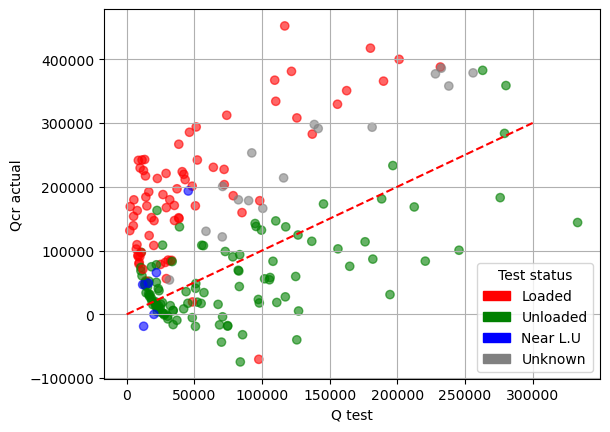

In [50]:
color_map = {
    "Loaded": "red",
    "Unloaded": "green",
    "Near L.U": "blue"
}

colors = df['Test status'].map(color_map).fillna("gray")

plt.scatter(gsflow, y_pred, c=colors, alpha=0.6, label="gplearn Predictions")
plt.plot([0, 300000], [0, 300000], '--r', label='Perfect Fit (y=x)')
plt.xlabel("Q test")
plt.ylabel("Qcr actual")
plt.grid(True)


legend_patches = [mpatches.Patch(color=color, label=status) for status, color in color_map.items()]
legend_patches.append(mpatches.Patch(color="gray", label="Unknown"))
plt.legend(handles=legend_patches, title='Test status')

plt.show()